In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [70]:
df = pd.read_csv('dataset.csv')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

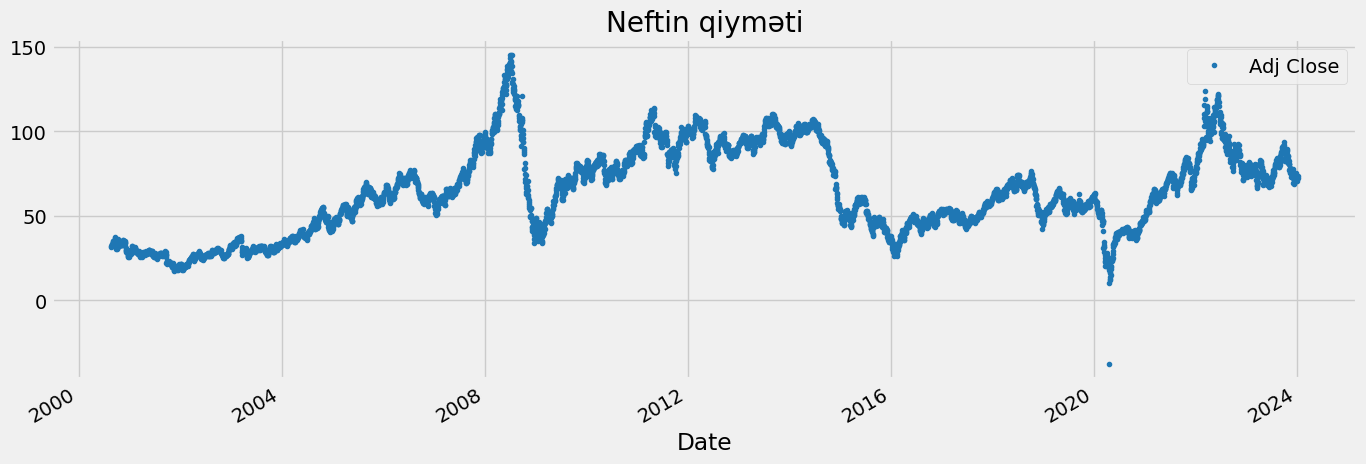

In [71]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Neftin qiyməti')
plt.show()

<Axes: ylabel='Frequency'>

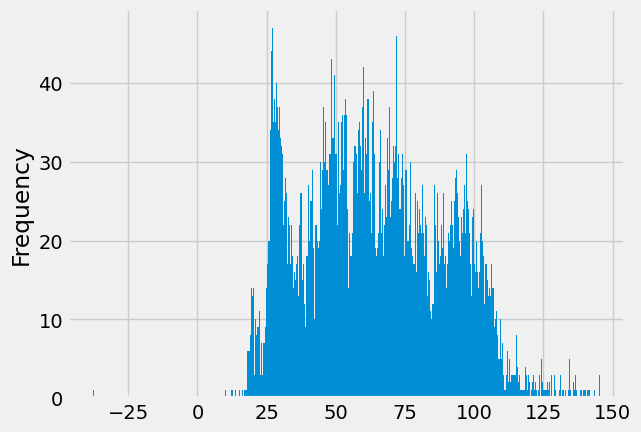

In [72]:
df['Adj Close'].plot(kind='hist', bins=500)


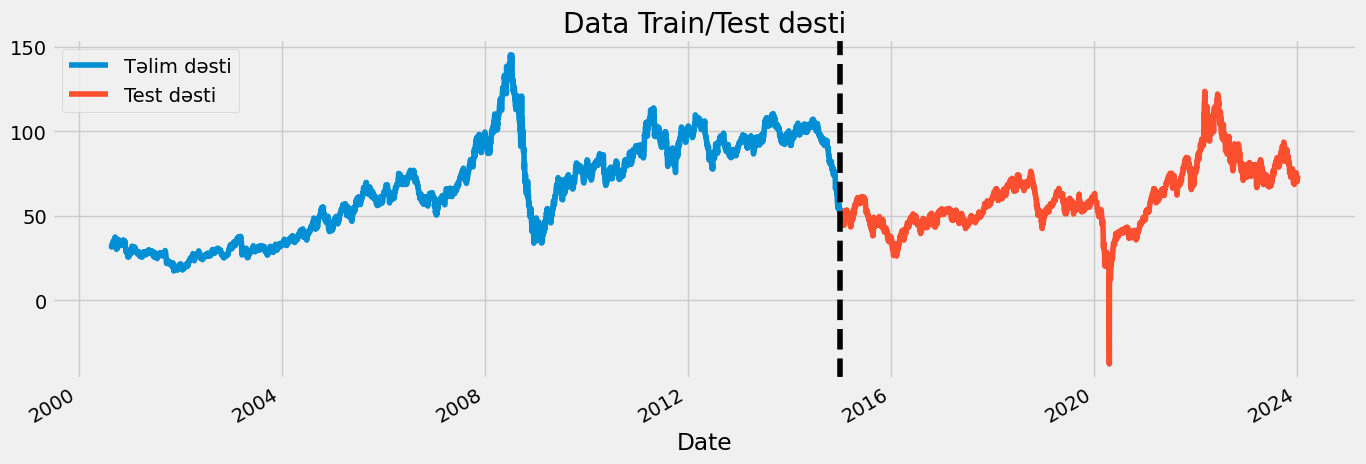

In [73]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Təlim dəsti', title='Data Train/Test dəsti')
test.plot(ax=ax, label='Test dəsti')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Təlim dəsti', 'Test dəsti'])
plt.show()

In [9]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=365*1, gap=24)
df = df.sort_index()

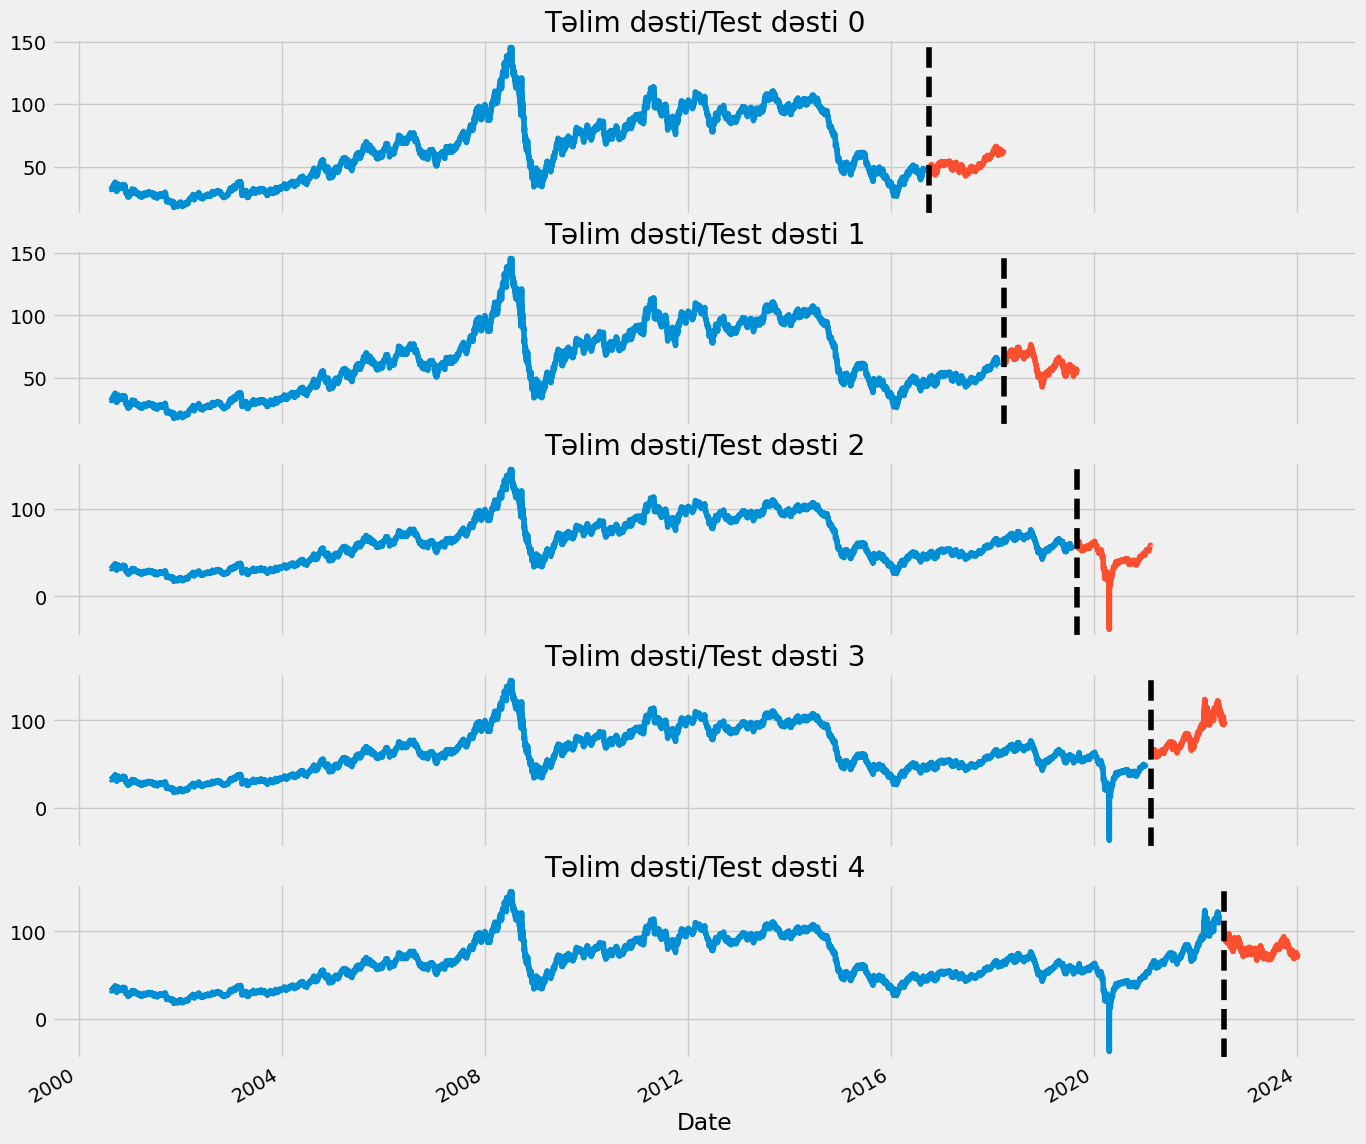

In [68]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Adj Close'].plot(ax=axs[fold],
                          label='Təlim dəsti',
                          title=f'Təlim dəsti/Test dəsti {fold}')
    test['Adj Close'].plot(ax=axs[fold],
                         label='Test dəsti')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [11]:
def create_features(df):
    """
    Zaman seriyası indeksinə əsaslanan zaman seriyası xüsusiyyətlərini tərtib edən funksiya.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [30]:
def add_lags(df):
    target_map = df['Adj Close'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('5 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('10 days')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    return df

In [31]:
df = add_lags(df)

In [41]:
tss = TimeSeriesSplit(n_splits=5, test_size=365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Adj Close'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:69.07722	validation_1-rmse:51.61970
[100]	validation_0-rmse:26.00932	validation_1-rmse:18.57629


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:09:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:10.25184	validation_1-rmse:6.82674
[300]	validation_0-rmse:4.68969	validation_1-rmse:2.98924
[400]	validation_0-rmse:2.96575	validation_1-rmse:1.81040
[500]	validation_0-rmse:2.47571	validation_1-rmse:1.70272
[541]	validation_0-rmse:2.38946	validation_1-rmse:1.69742
[0]	validation_0-rmse:67.72362	validation_1-rmse:61.06468
[100]	validation_0-rmse:25.42675	validation_1-rmse:23.22249


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:09:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:10.01200	validation_1-rmse:8.61948
[300]	validation_0-rmse:4.60007	validation_1-rmse:3.63101
[400]	validation_0-rmse:2.90945	validation_1-rmse:2.21371
[500]	validation_0-rmse:2.41322	validation_1-rmse:1.98499
[600]	validation_0-rmse:2.24344	validation_1-rmse:1.96110
[700]	validation_0-rmse:2.16481	validation_1-rmse:1.95504
[742]	validation_0-rmse:2.14200	validation_1-rmse:1.95494
[0]	validation_0-rmse:67.26312	validation_1-rmse:45.11972
[100]	validation_0-rmse:25.25528	validation_1-rmse:15.99490


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:09:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:9.94242	validation_1-rmse:7.83648
[300]	validation_0-rmse:4.55339	validation_1-rmse:6.56444
[400]	validation_0-rmse:2.87253	validation_1-rmse:6.22844
[500]	validation_0-rmse:2.41125	validation_1-rmse:5.82029
[600]	validation_0-rmse:2.23677	validation_1-rmse:5.40235
[700]	validation_0-rmse:2.16246	validation_1-rmse:5.17559
[800]	validation_0-rmse:2.11270	validation_1-rmse:5.06859
[900]	validation_0-rmse:2.06443	validation_1-rmse:4.92877
[999]	validation_0-rmse:2.03007	validation_1-rmse:4.85016
[0]	validation_0-rmse:65.93781	validation_1-rmse:82.71989
[100]	validation_0-rmse:24.83016	validation_1-rmse:31.71575


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:09:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:9.85517	validation_1-rmse:12.65091
[300]	validation_0-rmse:4.62835	validation_1-rmse:5.88710
[400]	validation_0-rmse:3.03698	validation_1-rmse:3.74918
[500]	validation_0-rmse:2.56808	validation_1-rmse:3.27223
[600]	validation_0-rmse:2.39903	validation_1-rmse:3.21008
[700]	validation_0-rmse:2.30855	validation_1-rmse:3.17639
[736]	validation_0-rmse:2.28689	validation_1-rmse:3.16992
[0]	validation_0-rmse:66.94584	validation_1-rmse:78.82816
[100]	validation_0-rmse:25.17976	validation_1-rmse:28.97987


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:09:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:9.96638	validation_1-rmse:10.79551
[300]	validation_0-rmse:4.65947	validation_1-rmse:4.40396
[400]	validation_0-rmse:3.04437	validation_1-rmse:2.64351
[500]	validation_0-rmse:2.59714	validation_1-rmse:2.29358
[600]	validation_0-rmse:2.42478	validation_1-rmse:2.23692
[679]	validation_0-rmse:2.34294	validation_1-rmse:2.23680


In [42]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 2.7780
Fold scores:[1.6895431649195307, 1.9544243468452849, 4.848007178280126, 3.168140793839154, 2.23003495272011]


In [43]:
df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3', 'lag4']
TARGET = 'Adj Close'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=10000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:67.91525
[100]	validation_0-rmse:25.51549


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:09:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:10.06021
[300]	validation_0-rmse:4.65266
[400]	validation_0-rmse:3.00102
[500]	validation_0-rmse:2.53686
[600]	validation_0-rmse:2.38254
[700]	validation_0-rmse:2.27889
[800]	validation_0-rmse:2.22794
[900]	validation_0-rmse:2.19406
[1000]	validation_0-rmse:2.16246
[1100]	validation_0-rmse:2.13975
[1200]	validation_0-rmse:2.11259
[1300]	validation_0-rmse:2.08600
[1400]	validation_0-rmse:2.06567
[1500]	validation_0-rmse:2.04439
[1600]	validation_0-rmse:2.03008
[1700]	validation_0-rmse:1.99892
[1800]	validation_0-rmse:1.97387
[1900]	validation_0-rmse:1.95204
[2000]	validation_0-rmse:1.92677
[2100]	validation_0-rmse:1.90239
[2200]	validation_0-rmse:1.88069
[2300]	validation_0-rmse:1.86484
[2400]	validation_0-rmse:1.84579
[2500]	validation_0-rmse:1.83064
[2600]	validation_0-rmse:1.81428
[2700]	validation_0-rmse:1.79904
[2800]	validation_0-rmse:1.78513
[2900]	validation_0-rmse:1.77348
[3000]	validation_0-rmse:1.76263
[3100]	validation_0-rmse:1.74976
[3200]	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [49]:
df.index.max()


Timestamp('2024-01-05 00:00:00')

In [60]:
future = pd.date_range('2024-01-05','2024-03-05', freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [61]:
future_w_features = df_and_future.query('isFuture').copy()

In [62]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

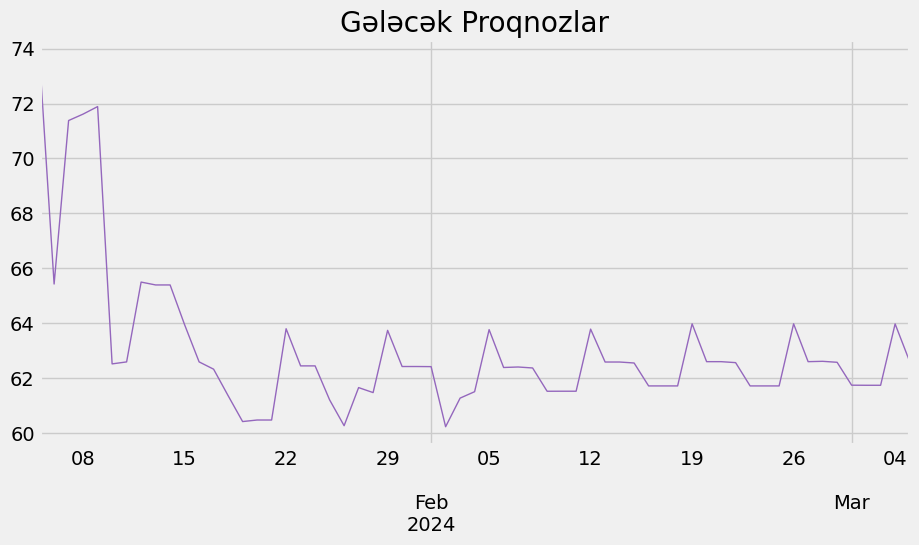

In [67]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Gələcək Proqnozlar')
plt.show()

In [64]:
reg.save_model('model.json')

<Axes: title={'center': 'Gələcək Proqnozlar'}>

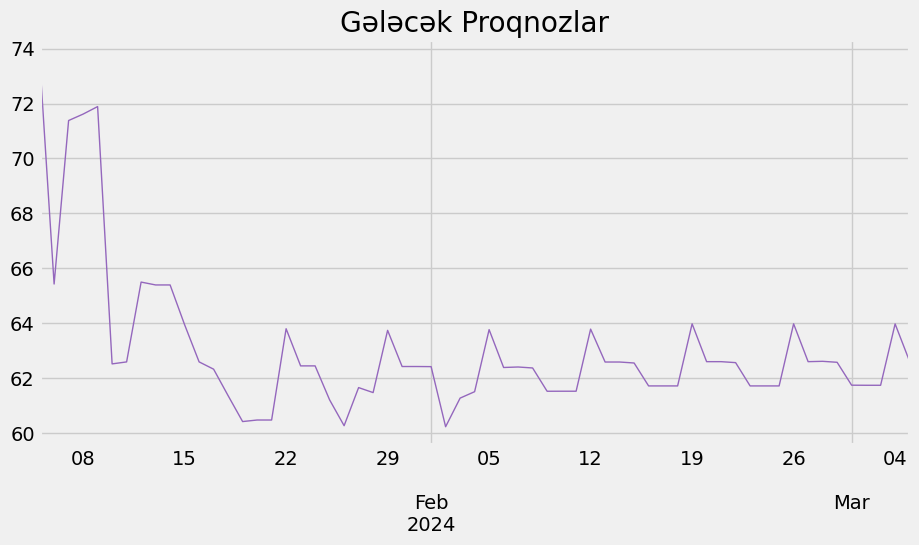

In [65]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Gələcək Proqnozlar')

In [66]:
future_w_features['pred']

2024-01-05    73.640884
2024-01-06    65.423943
2024-01-07    71.382263
2024-01-08    71.616516
2024-01-09    71.890381
                ...    
2024-03-01    61.736660
2024-03-02    61.733318
2024-03-03    61.733318
2024-03-04    63.970024
2024-03-05    62.605045
Name: pred, Length: 61, dtype: float32